In [1]:
import numpy as np

from scipy.signal import fftconvolve
from scipy.interpolate import interp1d
from scipy.optimize import minimize

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------
All data was extracted from Cai et al. (2011)

In [2]:
# Data extracted from Fig. 1
cai2011 = dict()

cai2011['100'] = np.array([0.46257, 0.00105, 0.97908, 0.13688, 1.92488, 1.00413,
                           2.93725, 1.00626, 3.94948, 1.01050, 4.92435, 1.01255,
                           5.93659, 1.01679, 6.92409, 1.01676, 7.94909, 1.01681]).reshape((-1, 2))
cai2011['200'] = np.array([0.47507, 0.00108, 0.95816, 0.07157, 1.95514, 0.71998,
                           2.93725, 1.00626, 3.93698, 1.01047, 4.92448, 1.01045,
                           5.94922, 1.01471, 6.93646, 1.01889, 7.93672, 1.01468]).reshape((-1, 2))
cai2011['300'] = np.array([0.47507, 0.00108, 0.99671, 0.05481, 1.95487, 0.52419,
                           2.93225, 0.88625, 3.93856, 0.98521, 4.94948, 1.01050,
                           5.93672, 1.01468, 6.93672, 1.01468, 7.94909, 1.01681]).reshape((-1, 2))

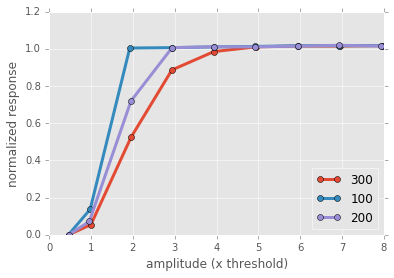

In [3]:
for cond in cai2011:
    plt.plot(cai2011[cond][:, 0], cai2011[cond][:, 1], 'o-', linewidth=3, label=cond)
plt.legend(loc='lower right')
plt.xlabel('amplitude (x threshold)')
plt.ylabel('normalized response')

# Model
-----------------

Following are all utily funcions used in this script.

In [4]:
class GanglionCell(object):
    def __init__(self, tsample, ca1_scale=1.0, ca1_tau=0.0191, ca2_scale=1.0, ca2_tau=14.0,
                 sig_a=3.0, sig_b=8.0):
        assert ca1_scale > 0
        assert ca2_scale > 0
        assert ca1_tau > 0
        assert ca2_tau >0
        self.ca1_tau = ca1_tau
        self.ca2_tau = ca2_tau
        self.ca1_scale = ca1_scale
        self.ca2_scale = ca2_scale
        self.tsample = tsample
        self.sig_a = sig_a
        self.sig_b = sig_b

        self.tau_nfl = 0.42 / 1000
        t = np.arange(0, 10 * self.tau_nfl, self.tsample)
        self.gamma_nfl = e2cm.gamma(1, self.tau_nfl, t)
        self.gamma_nfl /= np.trapz(self.gamma_nfl, dx=self.tsample)

        t = np.arange(0, 10 * self.ca1_tau, self.tsample)
        self.gamma_ca_fast = e2cm.gamma(1, self.ca1_tau, t)
        self.gamma_ca_fast /= np.trapz(self.gamma_ca_fast, dx=self.tsample)

#         t = np.arange(0, 10 * self.ca2_tau, self.tsample)
#         self.gamma_ca_slow = e2cm.gamma(1, self.ca2_tau, t)
#         self.gamma_ca_slow /= np.trapz(self.gamma_ca_slow, dx=self.tsample)

        
    def model_cascade(self, pt, dolayers=None, dojit=True):
        assert pt.tsample == self.tsample
        
        self.stim = pt
        self.ca_fast = pt.tsample * fftconvolve(np.abs(pt.data),
                                                  self.gamma_ca_fast, mode='full')[:pt.data.size]
#         self.ca_slow = pt.tsample * fftconvolve(np.abs(pt.data),
#                                                   self.gamma_ca_slow, mode='full')[:pt.data.size]

        self.r_impulse = pt.tsample * fftconvolve(pt.data, self.gamma_nfl)[:pt.data.size]
        
        self.r_adj = self.r_impulse - self.ca1_scale * self.ca_fast #- self.ca2_scale * self.ca_slow
        
        self.r_rgc = 100.0 / (1.0 + np.exp(-self.sig_a * self.r_adj + self.sig_b))
        
        return utils.TimeSeries(pt.tsample, self.r_rgc)

# Fit
----------

In [5]:
def run_cai2011_exp0(model, amp=1.0):
    # Finding threshold
    freq = 10.0
    pdur = 0.2 / 1000
    idur = 10.0 / 1000
    num_pulses = 1
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp0 = dict()
    stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=0.1,
                                  pulse_dur=pdur, interphase_dur=idur,
                                  pulsetype='cathodicfirst',
                                  delay=20.0 / 1000)
    mov = gcr.model_cascade(stim)
    exp0['gcr'] = gcr
    exp0['mov'] = mov
    exp0['resp'] = mov.data.max()
        
    return exp0

In [6]:
def run_cai2011_exp1(model, freqs=[100, 200, 300]):
    pdur = 0.2 / 1000
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp1 = dict()
    exp1['freqs'] = freqs
    exp1['amps'] = np.arange(9)
    for freq in freqs:
        cond = str(freq)
        exp1[cond] = dict()
        
        idur = 0.5 / freq
        
        resp = []
        for amp in exp1['amps']:
            stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=0.5,
                                          pulse_dur=pdur, interphase_dur=idur,
                                          pulsetype='cathodicfirst',
                                          delay=0.0 / 1000)
            mov = gcr.model_cascade(stim)
            resp.append(np.squeeze(mov.data.max()))

        exp1[cond]['resp'] = np.array(resp)
        exp1[cond]['norm_resp'] = (np.array(resp) + np.finfo(float).eps) / 100.0
        
    return exp1

In [7]:
def mse_cai2011_exp0(x):
    model = get_model(x)
    exp0 = run_cai2011_exp0(model)
    
    mse = np.abs(exp0['resp'] - 1.0) ** 2
#     print('%s: %.7f' % (str([('%.7f' % xx) for xx in x]), mse))

    return mse

In [8]:
def mse_cai2011_exp1(x, cai2011, freqs):
    model = get_model(x)
    exp1 = run_cai2011_exp1(model, freqs)
    
    mse = 0
    for freq in exp1['freqs']:
        cond = str(freq)
        
        mse += np.mean(np.abs(exp1[cond]['norm_resp'] - cai2011[cond][:, 1]) ** 2)
    
#     print('%s: %.7f' % (str([('%.7f' % xx) for xx in x]), mse))
    return mse

In [9]:
def mse_cai2011_all(x, freeman, exp1_freqs=[2, 4, 8, 16]):
    mse = 0
    
    mse += mse_cai2011_exp0(x) * 100.0
    mse += mse_cai2011_exp1(x, cai2011, exp1_freqs)
    
    print('%s: %.9f' % (str([('%.9f' % xx) for xx in x]), mse))
    return mse

In [10]:
def get_model(x, amp_th=50.0):
    tsample = 0.005 / 1000

    [k1, a, b] = x
    model = dict()
    
    # Stimulating electrode remained 25um above the inner limiting membrane
    model['implant'] = e2cm.ElectrodeArray('epiretinal', 40.0 / 2, -500, -500, 25.0)

    r_sampling = 100
    axon_lambda = 2 
    model['retina'] = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=0,
                                  xlo=model['implant'][0].x_center,
                                  xhi=model['implant'][0].x_center,
                                  ylo=model['implant'][0].y_center,
                                  yhi=model['implant'][0].y_center)

    model['gcr'] = GanglionCell(tsample, ca1_scale=k1, ca1_tau=0.0191, #ca2_scale=k2, ca2_tau=7.1345,
                                sig_a=a, sig_b=b)
    
    return model

In [11]:
amp_th = 50.0
exp1_freqs = [100, 200, 300]

In [12]:
res = minimize(mse_cai2011_all, [1.0, 3.0, 8.0], args=(cai2011, exp1_freqs),
               method='L-BFGS-B', bounds=[(0.1, 100.0), (0.0, 100.0), (0.01, 50.0)])

['1.000000000', '3.000000000', '8.000000000']: 82.652407645
['1.000000010', '3.000000000', '8.000000000']: 82.652407655
['1.000000000', '3.000000010', '8.000000000']: 82.652407573
['1.000000000', '3.000000000', '8.000000010']: 82.652407827
['0.100000000', '10.165741067', '0.010000000']: 938266.935333452
['0.100000010', '10.165741067', '0.010000000']: 938266.935265432
['0.100000000', '10.165741077', '0.010000000']: 938266.935486202
['0.100000000', '10.165741067', '0.010000010']: 938266.934928516
['0.999962586', '3.000297885', '7.999667850']: 82.644194981
['0.999962596', '3.000297885', '7.999667850']: 82.644194991
['0.999962586', '3.000297895', '7.999667850']: 82.644194909
['0.999962586', '3.000297885', '7.999667860']: 82.644195163
['0.549981293', '6.583019476', '4.004833925']: 26289.429742558
['0.549981303', '6.583019476', '4.004833925']: 26289.429692290
['0.549981293', '6.583019486', '4.004833925']: 26289.429913445
['0.549981293', '6.583019476', '4.004833935']: 26289.429280434
['0.8696

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: RuntimeWarning: overflow encountered in exp


['11.659038989', '47.978457312', '13.531374422']: 0.005968339
['11.659038999', '47.978457312', '13.531374422']: 0.005968341
['11.659038989', '47.978457322', '13.531374422']: 0.005968338
['11.659038989', '47.978457312', '13.531374432']: 0.005968342
['11.575351251', '47.426002873', '13.492636996']: 0.005740838
['11.575351261', '47.426002873', '13.492636996']: 0.005740838
['11.575351251', '47.426002883', '13.492636996']: 0.005740838
['11.575351251', '47.426002873', '13.492637006']: 0.005740839
['11.622431490', '47.639475328', '13.495698006']: 0.005717534
['11.622431500', '47.639475328', '13.495698006']: 0.005717534
['11.622431490', '47.639475338', '13.495698006']: 0.005717534
['11.622431490', '47.639475328', '13.495698016']: 0.005717534
['11.631675181', '47.546896454', '13.470512804']: 0.005724573
['11.631675191', '47.546896454', '13.470512804']: 0.005724572
['11.631675181', '47.546896464', '13.470512804']: 0.005724573
['11.631675181', '47.546896454', '13.470512814']: 0.005724572
['11.626

# Plot
----------

In [13]:
print(res)

      fun: 0.0051818624327699975
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6.08900083e-05,  -1.01305249e-05,   5.93715181e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1688
      nit: 303
   status: 0
  success: True
        x: array([ 12.67411387,  61.02546509,  14.93567431])


In [14]:
test_freqs = [100, 200, 300]
model = get_model(res.x)
exp1 = run_cai2011_exp1(model, test_freqs)

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: RuntimeWarning: overflow encountered in exp


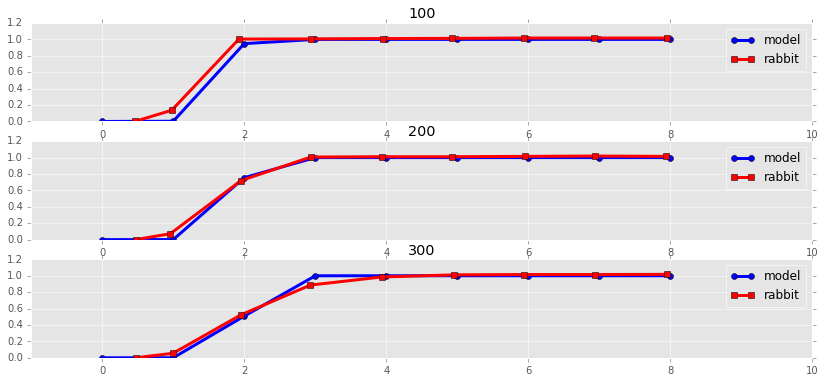

In [15]:
num_cols = np.floor(np.sqrt(len(test_freqs)))
num_rows = np.ceil(len(test_freqs) / num_cols)
plt.figure(figsize=(14, 6))
for i, freq in enumerate(test_freqs):
    freqstr = str(freq)
    plt.subplot(num_rows, num_cols, i + 1)
    if 'norm_resp' in exp1[freqstr]:
        plt.plot(exp1[freqstr]['norm_resp'], 'o-b',
                 linewidth=3, label='model')
    if freqstr in cai2011:
        plt.plot(cai2011[freqstr][:, 0],
                 cai2011[freqstr][:, 1], 's-r',
                 linewidth=3, label='rabbit')
    plt.title(freqstr)
    plt.ylim(0, 1.2)
    plt.xlim(-1, 10)
    plt.legend(loc='best')

In [16]:
exp0 = run_cai2011_exp0(model)

In [17]:
exp0['resp']

1.0000003449673092